<a href="https://colab.research.google.com/github/mghadam/research/blob/main/Measuring_Information_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core Idea: Using Transfer Entropy to measure Information Transfer

The base of this idea is this [paper](https://link.aps.org/doi/10.1103/PhysRevLett.85.461). 

Let's check transfer entropy for a sample stock.


Installing and loading required python packages

In [ ]:
!pip install yfinance
import pandas, yfinance, numpy
import matplotlib.pyplot as plt

Importing Google's stock data

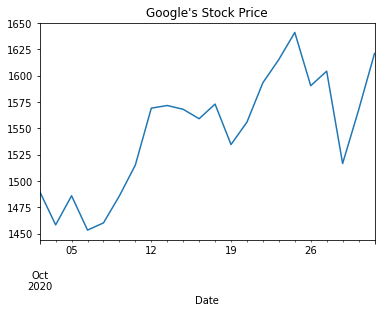

In [ ]:
# get the historical prices for this ticker)
tickerDf = yfinance.Ticker('GOOG').history(start='2020-10-1', end='2020-11-1')

# plot the price data
tickerDf['Close'].plot(title="Google's Stock Price")


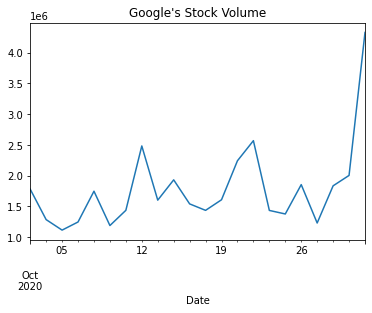

In [ ]:
# plot the volume data
tickerDf['Volume'].plot(title="Google's Stock Volume")

Calculating price and volume action borders

In [ ]:
priceaction = numpy.sign(tickerDf['Close'].diff()[1:])
volumeaction = numpy.sign(tickerDf['Volume'].diff()[1:])

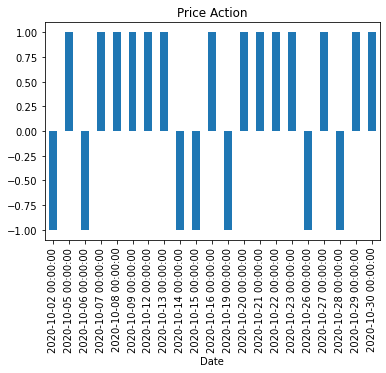

In [ ]:
priceaction.plot(kind="bar", title="Price Action")

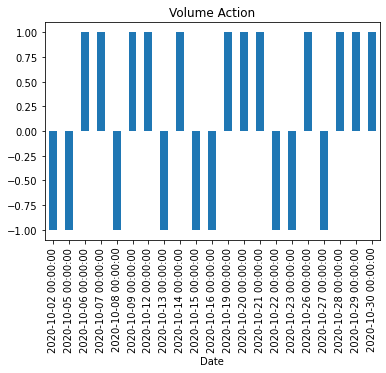

In [ ]:
volumeaction.plot(kind="bar", title="Volume Action")


## Calculating Transfer Entropy

There are opensource implementations of TransferEntropy however they are complicated and also they are for real variables rather than binary variables. Our price and volume action borders are binary. So we need to develop our own code to understand TransferEntropy.

We use a simple notion of Transfer Entropy explained [here](https://users.utu.fi/attenka/TEpresentation081128.pdf) by [Atte Tenkanen](https://users.utu.fi/attenka/) to develop our code.

Mutual Information and Transfer Entropy functions:

In [ ]:
import numpy

def invb(z):
  '''Takes a binary numpy array and returns its inverse array'''
  return (z-1)*(-1)
  
def mi(x,y):
  '''Takes two binary numpy arrays x,y and returns their mutual information'''
  l = x.size
  # p(0), p(1)
  px = numpy.array([1-x.sum()/l, x.sum()/l])
  py = numpy.array([1-y.sum()/l, y.sum()/l])

  # pxy(0,0), p(0,1), p(1,0), p(1,1)
  pxy = numpy.array([[(invb(x)*invb(y)).sum()/l, (invb(x)*y).sum()/l], [(x*invb(y)).sum()/l, (x*y).sum()/l]])

  # Adding epsilon to the above to avoid log(0)
  epsilon = numpy.finfo(float).eps
  px += epsilon
  py += epsilon
  pxy += epsilon

  # Calculate MI
  sum = 0
  for j in range(2):
    for i in range(2):
      # We should actually use log2 instead of log10 as we have binary data
      # but for validation with the benchmark in the slides, we have to use log10
      sum += pxy[i,j] * numpy.log10 ( pxy[i,j] / (px[i]*py[j]))

  return sum 

def te(x,y):
  '''Takes two binary numpy arrays x,y and retursn their transfer entropy X->Y'''
  l = x.size

  # p(0,1)
  px = numpy.array([1-x.sum()/l, x.sum()/l])
  py = numpy.array([1-y.sum()/l, y.sum()/l])

  # pxy(0,0), p(0,1), p(1,0), p(1,1)
  pxy = numpy.array([[(invb(x)*invb(y)).sum()/l, (invb(x)*y).sum()/l], [(x*invb(y)).sum()/l, (x*y).sum()/l]])

  # Y = y[n+1] -> y[1:]
  # pXx(0,0), p(0,1), p(1,0), p(1,1)
  pYy = numpy.array([
                     [(invb(y[1:])*invb(y[:-1])).sum()/(l-1),  (invb(y[1:])*y[:-1]).sum()/(l-1)],
                     [(y[1:]*invb(y[:-1])).sum()/(l-1),  (y[1:]*y[:-1]).sum()/(l-1)],
  ])

  # pXxy[n+1,n,n]
  pYxy = numpy.array([[
                       [(invb(y[1:])*invb(x[:-1])*invb(y[:-1])).sum()/(l-1), (invb(y[1:])*invb(x[:-1])*y[:-1]).sum()/(l-1)],
                       [(invb(y[1:])*x[:-1]*invb(y[:-1])).sum()/(l-1), (invb(y[1:])*x[:-1]*y[:-1]).sum()/(l-1)]
                      ]
                      ,[
                        [(y[1:]*invb(x[:-1])*invb(y[:-1])).sum()/(l-1), (y[1:]*invb(x[:-1])*y[:-1]).sum()/(l-1)],
                        [(y[1:]*x[:-1]*invb(y[:-1])).sum()/(l-1), (y[1:]*x[:-1]*y[:-1]).sum()/(l-1)]
                       ]
                      ])
  # Adding epsilon to the above to avoid log(0)
  epsilon = numpy.finfo(float).eps
  px += epsilon
  pxy += epsilon
  pYy += epsilon
  pYxy += epsilon

  # Calculating TE
  sum = 0
  for i in range(2):
    for j in range(2):
      for k in range(2):
        # We should actually use log2 instead of log10 as we have binary data
        # but for validation with the benchmark in the slides, we have to use log10
        sum += pYxy[i,j,k] * numpy.log2(pYxy[i,j,k] * py[k] / (pxy[j,k] * pYy[i,k]))

  return sum

Now lets test our functions with benchmarks provided in Tenkanen's slides:

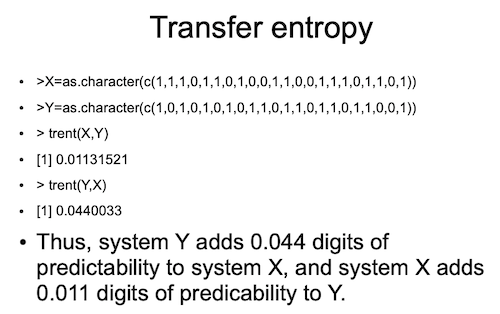

In [ ]:
x=numpy.array([1,1,1,0,1,1,0,1,0,0,1,1,0,0,1,1,1,0,1,1,0,1])
y=numpy.array([1,0,1,0,1,0,1,0,1,1,0,1, 1,0,1,1,0,1,1,0,0,1])
print(" MI: {:.7f}\n TE X->Y: {:.7f}\n TE Y->X: {:.7f}".format(
    mi(x,y),
    te(x,y),
    te(y,x)
))

 MI: 0.0005992
 TE X->Y: 0.0375883
 TE Y->X: 0.1461758


Looking good!

Now we can calculate TE of our action borders:

In [ ]:
def actionv(z):
  ''' Converts a binary border from -1,1 values to 0,1'''
  return (z+1)/2

p = actionv( priceaction.to_numpy() )
v = actionv( volumeaction.to_numpy() )

print("TE P->V: {:.7f}\nTE V->P: {:.7f}".format(
    te(p,v),
    te(v,p)
))

TE P->V: 0.2124509
TE V->P: 0.3520922


Thus for our sample, price adds 0.064 digits of predictability to volume, and volume adds 0.106 of predictability to price.

## Tests to understand Transfer Entropy

Here we run several tests to evaluate how our transfer entropy functions work in action

### Test #1: checking TE for random series of data

We want to see what value TE calculates for two random series of data that have no relation to each other

In [ ]:
size = 100
iterations = 1000

tes = numpy.zeros([iterations,2])
for k in range(iterations):
  randp = actionv( numpy.sign(numpy.random.rand(size)-0.5) )
  randv = actionv( numpy.sign(numpy.random.rand(size)-0.5) )
  tes[k,0] = te(randp,randv)
  tes[k,1] = te(randv,randp)
  

print("Size: {}\nAverage TE P->V after {} iterations: {:.7f}\nAverage TE V->P after {} iterations: {:.7f}\n\n".format(
    size,
    iterations,
    numpy.average(tes[:,0]),
    iterations,
    numpy.average(tes[:,1])
))

Size: 100
Average TE P->V after 1000 iterations: 0.0156239
Average TE V->P after 1000 iterations: 0.0141741




As it is seen, the average TE is quite low for random sequence of action borders.

### Test #2: Make a shift in two related sequences and see how delay can affect TE

randp border is a random sequence, however randv is no more random. It is randp, rolled by one bit. 

In [ ]:
size = 100
iterations = 1000

tes = numpy.zeros([iterations,2])
for k in range(iterations):
  randp = actionv( numpy.sign(numpy.random.rand(size)-0.5) )
  randv = numpy.roll(randp,1)
  tes[k,0] = te(randp,randv)
  tes[k,1] = te(randv,randp)

print("Size: {}\nAverage TE P->V after {} iterations: {:.7f}\nAverage TE V->P after {} iterations: {:.7f}\n\n".format(
    size,
    iterations,
    numpy.average(tes[:,0]),
    iterations,
    numpy.average(tes[:,1])
))

Size: 100
Average TE P->V after 1000 iterations: 0.9856343
Average TE V->P after 1000 iterations: 0.0151050




Result: TE for P->V is ~ 0.3 for 1 bit of rolling.

If we change the rolling to 2 bits, TE will not detect it at all. I think this is because of Window size. There was a feature in TE formulations called Window Size that we were able to set how far TE sees data transfer.

We have not implemented Window Size in our codes yet. We should get better results after implementing this feature. 

  ### Test #3 add 1% error in Y then find Peak of TE

  How are we going to implement this?

https://code.google.com/archive/p/transfer-entropy-toolbox/

Transfer Entropy Toolbox (TET) provides binary TE with advanced functions such as window size (history bin size). Need to use this packagae to avoid reinventing the wheel. 